In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

In [2]:
model = "dualPowerLaw"
period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61

# dataStr = "Sc0.7" or "Sc0.9" or ""
dataStr = ""
if dataStr == "Sc0.9":
    fnStr = "Sc0p9"
    hrFpeModel = "constant"
    hcFpeModel = "constant"
    fpwgpcFpeModel = "constant"
    dr25FpeModel = "constant"
elif dataStr == "Sc0.7":
    fnStr = "Sc0p7"
    hrFpeModel = "constant"
    hcFpeModel = "constant"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "constant"
elif dataStr == "Sc0.6":
    fnStr = "Sc0p6"
    hrFpeModel = "constant"
    hcFpeModel = "rotatedLogisticX0"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "rotatedLogisticX0"
elif dataStr == "":
    fnStr = ""
    hrFpeModel = "constant"
    hcFpeModel = "rotatedLogisticX0"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "rotatedLogisticX0"
outputDir = "caseComparison" + dataStr



In [3]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [4]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)





In [5]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta


In [6]:
capsize = 8
cbc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def draw_dists(dr25, hr, hc, fpwg, xlimMax, drawLegend = False):
    plt.figure(figsize=(15,6));
    ylim = plt.ylim()
    plt.hist(dr25, 50, histtype="step", color=cbc[3], density=True);
    plt.hist(hr, 50, histtype="step", color=cbc[0], density=True);
    plt.hist(hc, 50, histtype="step", color=cbc[1], density=True);
    plt.hist(fpwg, 50, histtype="step", color=cbc[2], density=True);
    ylim = plt.ylim()
    # plt.xscale('log')
    xlim = plt.xlim()
    plt.xlim(xlim[0], xlimMax)
    hrStats = medianAndErrorbars(hr)
    hcStats = medianAndErrorbars(hc)
    fpwgpcStats = medianAndErrorbars(fpwg)
    dr25Stats = medianAndErrorbars(dr25)
    l1 = plt.errorbar(dr25Stats[0], 1.04*ylim[1], xerr=[[dr25Stats[2]],[dr25Stats[1]]], capsize = capsize, color = cbc[3], fmt='--d')
    l2 = plt.errorbar(hrStats[0], 1.02*ylim[1], xerr=[[hrStats[2]],[hrStats[1]]], capsize = capsize, color = cbc[0], fmt='--o')
    l3 = plt.errorbar(hcStats[0], 1.0*ylim[1], xerr=[[hcStats[2]],[hcStats[1]]], capsize = capsize, color = cbc[1], fmt='--s')
    l4 = plt.errorbar(fpwgpcStats[0], 0.98*ylim[1], xerr=[[fpwgpcStats[2]],[fpwgpcStats[1]]], capsize = capsize, color = cbc[2], fmt='--*')
    plt.gca().set_yticklabels([])
    plt.tick_params(labelsize = 24)
    if drawLegend:
        plt.legend([l1, l2, l3, l4], ["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize=24)
    
    medianVec = [hrStats[0], hcStats[0], fpwgpcStats[0], dr25Stats[0]]
    sigmaVecPlus = [hrStats[1], hcStats[1], fpwgpcStats[1], dr25Stats[1]]
    sigmaVecMinus = [hrStats[2], hcStats[2], fpwgpcStats[2], dr25Stats[2]]
    sigmaVec = [sigmaVecPlus,sigmaVecMinus]
    
    separation = np.zeros((len(medianVec), len(medianVec)))
    separationSigma = np.zeros((len(medianVec), len(medianVec)))
    separationInSigma = np.zeros((len(medianVec), len(medianVec)))
    for i in range(len(medianVec)):
        for j in range(i):
            separation[i,j] = np.abs(medianVec[i]-medianVec[j])
            if medianVec[i] > medianVec[j]:
                # i > j, so use i minus and j plus
                separationSigma[i,j] = np.sqrt(sigmaVecMinus[i]**2 + sigmaVecPlus[j]**2)
            else:
                # i <= j, so use i plus and j minus
                separationSigma[i,j] = np.sqrt(sigmaVecPlus[i]**2 + sigmaVecMinus[j]**2)
            if separationSigma[i,j] > 0:
                separationInSigma[i,j] = separation[i,j]/separationSigma[i,j]
            
#     print(separation)
#     print(separationSigma)
#     print(separationInSigma)
            
    print("Range of medians: " 
         + str(np.round(np.min(medianVec),2)) + " to " + str(np.round(np.max(medianVec),2)))
    print("std of medians: " 
         + str(np.round(np.std(medianVec),2)) + " = " + str(np.round(100*np.std(medianVec)/np.mean(medianVec),2)) + "%")
    print("peak-to-peak of medians: " 
         + str(np.round(np.ptp(medianVec),2)) + " = " + str(np.round(100*np.ptp(medianVec)/np.mean(medianVec),2)) + "%")
    print("peak-to-peak of medians: " 
         + str(np.round(np.ptp(medianVec),2)) + " = " + str(np.round(np.ptp(medianVec)/np.linalg.norm(sigmaVec),2)) + " sigma")
    print("Maximum separation of medians: " + str(np.round(np.max(separationInSigma), 3)) + " sigma")

    

In [7]:
hrPosteriorsNoReliability = np.load("highReliability" + dataStr + "Output/occurenceRatePosteriors_noreliability.npy")
hrPosteriorsWithReliability = np.load("highReliability" + dataStr + "Output/occurenceRatePosteriors.npy")

hcPosteriorsNoReliability = np.load("highCompleteness" + dataStr + "Output/occurenceRatePosteriors_noreliability.npy")
hcPosteriorsWithReliability = np.load("highCompleteness" + dataStr + "Output/occurenceRatePosteriors.npy")

fpwgpcPosteriorsNoReliability = np.load("fpwgpc" + dataStr + "Output/occurenceRatePosteriors_noreliability.npy")
fpwgpcPosteriorsWithReliability = np.load("fpwgpc" + dataStr + "Output/occurenceRatePosteriors.npy")

dr25PosteriorsNoReliability = np.load("dr25" + dataStr + "Output/occurenceRatePosteriors_noreliability.npy")
dr25PosteriorsWithReliability = np.load("dr25" + dataStr + "Output/occurenceRatePosteriors.npy")


In [8]:
print("F_0 High Reliability Without Reliability = " + printMedianAndErrorbars(hrPosteriorsNoReliability[:,0]))
print("F_0 High Reliability With Reliability = " + printMedianAndErrorbars(hrPosteriorsWithReliability[:,0]))

print("F_0 High Completeness Without Reliability = " + printMedianAndErrorbars(hcPosteriorsNoReliability[:,0]))
print("F_0 High Completeness With Reliability = " + printMedianAndErrorbars(hcPosteriorsWithReliability[:,0]))

print("F_0 fpwgpc Without Reliability = " + printMedianAndErrorbars(fpwgpcPosteriorsNoReliability[:,0]))
print("F_0 fpwgpc With Reliability = " + printMedianAndErrorbars(fpwgpcPosteriorsWithReliability[:,0]))

print("F_0 DR25 Without Reliability = " + printMedianAndErrorbars(dr25PosteriorsNoReliability[:,0]))
print("F_0 DR25 With Reliability = " + printMedianAndErrorbars(dr25PosteriorsWithReliability[:,0]))


F_0 High Reliability Without Reliability = 0.527^{+0.099}_{-0.083}
F_0 High Reliability With Reliability = 0.416^{+0.085}_{-0.069}
F_0 High Completeness Without Reliability = 0.863^{+0.166}_{-0.133}
F_0 High Completeness With Reliability = 0.449^{+0.096}_{-0.076}
F_0 fpwgpc Without Reliability = 0.939^{+0.171}_{-0.140}
F_0 fpwgpc With Reliability = 0.485^{+0.102}_{-0.084}
F_0 DR25 Without Reliability = 0.612^{+0.115}_{-0.091}
F_0 DR25 With Reliability = 0.444^{+0.092}_{-0.074}


Range of medians: 0.53 to 0.94
std of medians: 0.17 = 23.22%
peak-to-peak of medians: 0.41 = 56.03%
peak-to-peak of medians: 0.41 = 1.13 sigma
Maximum separation of medians: 2.404 sigma


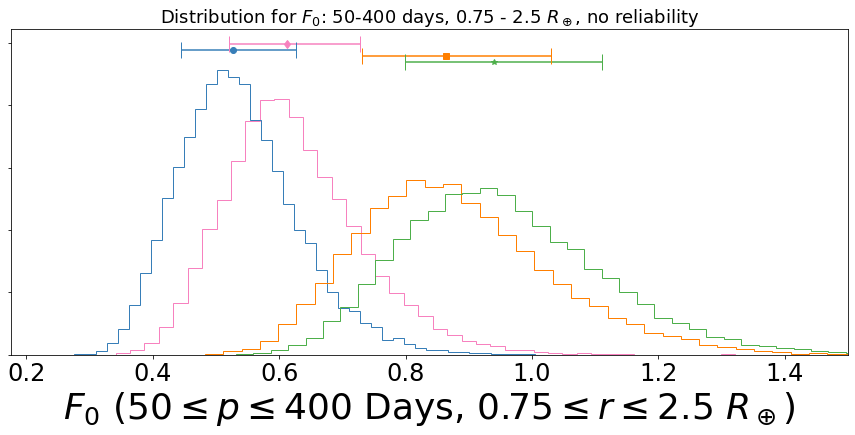

In [9]:
draw_dists(dr25PosteriorsNoReliability[:,0], hrPosteriorsNoReliability[:,0], hcPosteriorsNoReliability[:,0], 
           fpwgpcPosteriorsNoReliability[:,0], 1.5)
plt.xlabel(r"$F_0$ ($50 \leq p \leq 400$ Days, $0.75 \leq r \leq 2.5~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/f0DistNoReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, no reliability", fontsize=18);


Range of medians: 0.42 to 0.48
std of medians: 0.02 = 5.48%
peak-to-peak of medians: 0.07 = 15.44%
peak-to-peak of medians: 0.07 = 0.29 sigma
Maximum separation of medians: 0.577 sigma


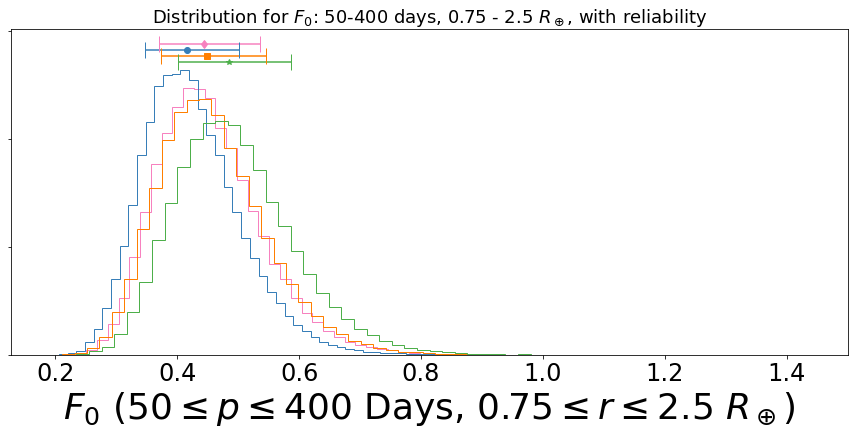

In [10]:
draw_dists(dr25PosteriorsWithReliability[:,0], hrPosteriorsWithReliability[:,0], hcPosteriorsWithReliability[:,0], 
           fpwgpcPosteriorsWithReliability[:,0], 1.5)
plt.xlabel(r"$F_0$ ($50 \leq p \leq 400$ Days, $0.75 \leq r \leq 2.5~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/f0DistWithReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, with reliability", fontsize=18);


In [11]:
def compute_gamma_earth(samples):

    gamma_earth = np.empty((len(samples)))

    for i,p in enumerate(samples):
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
        
    return gamma_earth


In [12]:
gammaEarthHrNr = compute_gamma_earth(hrPosteriorsNoReliability)
gammaEarthHrWr = compute_gamma_earth(hrPosteriorsWithReliability)

gammaEarthHcNr = compute_gamma_earth(hcPosteriorsNoReliability)
gammaEarthHcWr = compute_gamma_earth(hcPosteriorsWithReliability)

gammaEarthFpwgpcNr = compute_gamma_earth(fpwgpcPosteriorsNoReliability)
gammaEarthFpwgpcWr = compute_gamma_earth(fpwgpcPosteriorsWithReliability)

gammaEarthDistDr25Nr = compute_gamma_earth(dr25PosteriorsNoReliability)
gammaEarthDistDr25Wr = compute_gamma_earth(dr25PosteriorsWithReliability)


In [13]:
print("Gamma_Earth High Reliability Without Reliability = " + printMedianAndErrorbars(gammaEarthHrNr))
print("Gamma_Earth High Reliability With Reliability = " + printMedianAndErrorbars(gammaEarthHrWr))

print("Gamma_Earth High Completeness Without Reliability = " + printMedianAndErrorbars(gammaEarthHcNr))
print("Gamma_Earth High Completeness With Reliability = " + printMedianAndErrorbars(gammaEarthHcWr))

print("Gamma_Earth fpwgpc Without Reliability = " + printMedianAndErrorbars(gammaEarthFpwgpcNr))
print("Gamma_Earth fpwgpc With Reliability = " + printMedianAndErrorbars(gammaEarthFpwgpcWr))

print("Gamma_Earth DR25 Without Reliability = " + printMedianAndErrorbars(gammaEarthDistDr25Nr))
print("Gamma_Earth DR25 With Reliability = " + printMedianAndErrorbars(gammaEarthDistDr25Wr))


Gamma_Earth High Reliability Without Reliability = 0.142^{+0.086}_{-0.056}
Gamma_Earth High Reliability With Reliability = 0.079^{+0.059}_{-0.035}
Gamma_Earth High Completeness Without Reliability = 0.466^{+0.222}_{-0.154}
Gamma_Earth High Completeness With Reliability = 0.104^{+0.075}_{-0.045}
Gamma_Earth fpwgpc Without Reliability = 0.552^{+0.235}_{-0.173}
Gamma_Earth fpwgpc With Reliability = 0.128^{+0.085}_{-0.055}
Gamma_Earth DR25 Without Reliability = 0.217^{+0.114}_{-0.077}
Gamma_Earth DR25 With Reliability = 0.102^{+0.070}_{-0.043}


Range of medians: 0.14 to 0.55
std of medians: 0.17 = 49.26%
peak-to-peak of medians: 0.41 = 119.14%
peak-to-peak of medians: 0.41 = 0.95 sigma
Maximum separation of medians: 2.124 sigma


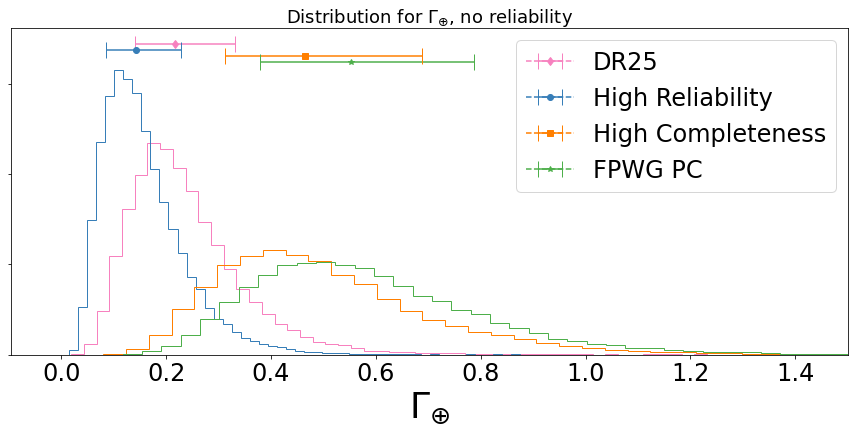

In [14]:
draw_dists(gammaEarthDistDr25Nr, gammaEarthHrNr, gammaEarthHcNr, gammaEarthFpwgpcNr, 1.5, True)
plt.xlabel(r"$\Gamma_{\oplus}$", fontSize = 36);
plt.savefig(outputDir + "/gammaEarthDistNoReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $\Gamma_{\oplus}$, no reliability", fontsize=18);


Range of medians: 0.08 to 0.13
std of medians: 0.02 = 16.67%
peak-to-peak of medians: 0.05 = 47.08%
peak-to-peak of medians: 0.05 = 0.28 sigma
Maximum separation of medians: 0.607 sigma


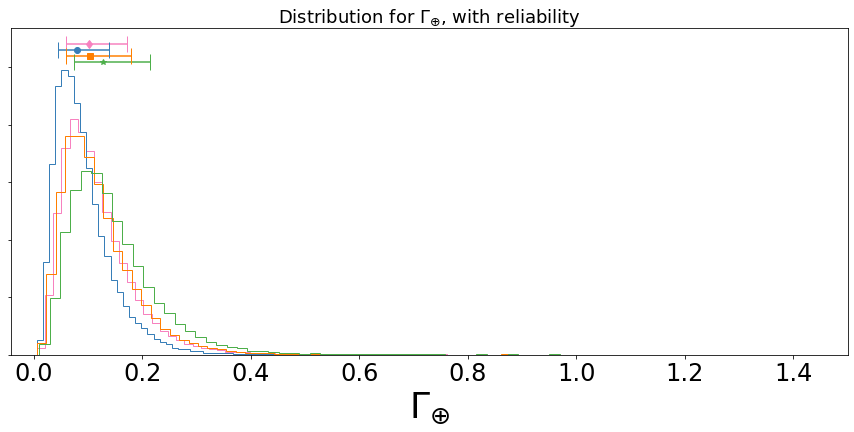

In [15]:
draw_dists(gammaEarthDistDr25Wr, gammaEarthHrWr, gammaEarthHcWr, gammaEarthFpwgpcWr, 1.5)
plt.xlabel(r"$\Gamma_{\oplus}$", fontSize = 36);
plt.savefig(outputDir + "/gammaEarthDistWithReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $\Gamma_{\oplus}$, with reliability", fontsize=18);


In [16]:
fileName = outputDir + "/F1Posteriors.npz"

if path.exists(fileName): 
    npzFiles=np.load(fileName)    
    F1DistHrNr=npzFiles['F1DistHrNr']
    F1DistHrWr=npzFiles['F1DistHrWr']
    F1DistHcNr=npzFiles['F1DistHcNr']
    F1DistHcWr=npzFiles['F1DistHcWr']
    F1DistFpwgpcNr=npzFiles['F1DistFpwgpcNr']
    F1DistFpwgpcWr=npzFiles['F1DistFpwgpcWr']
    F1DistDr25Nr=npzFiles['F1DistDr25Nr']
    F1DistDr25Wr=npzFiles['F1DistDr25Wr']
else:
    F1PeriodRange = [50.,200.];
    F1RadiusRange = [1., 2.];

    F1DistHrNr = integrateRateModel(F1PeriodRange, F1RadiusRange, hrPosteriorsNoReliability, model)
    F1DistHrWr = integrateRateModel(F1PeriodRange, F1RadiusRange, hrPosteriorsWithReliability, model)

    F1DistHcNr = integrateRateModel(F1PeriodRange, F1RadiusRange, hcPosteriorsNoReliability, model)
    F1DistHcWr = integrateRateModel(F1PeriodRange, F1RadiusRange, hcPosteriorsWithReliability, model)

    F1DistFpwgpcNr = integrateRateModel(F1PeriodRange, F1RadiusRange, fpwgpcPosteriorsNoReliability, model)
    F1DistFpwgpcWr = integrateRateModel(F1PeriodRange, F1RadiusRange, fpwgpcPosteriorsWithReliability, model)

    F1DistDr25Nr = integrateRateModel(F1PeriodRange, F1RadiusRange, dr25PosteriorsNoReliability, model)
    F1DistDr25Wr = integrateRateModel(F1PeriodRange, F1RadiusRange, dr25PosteriorsWithReliability, model)

    np.savez(outputDir + "/F1Posteriors", 
         F1DistHrNr=F1DistHrNr, F1DistHrWr=F1DistHrWr,
         F1DistHcNr=F1DistHcNr, F1DistHcWr=F1DistHcWr,
         F1DistFpwgpcNr=F1DistFpwgpcNr, F1DistFpwgpcWr=F1DistFpwgpcWr,
         F1DistDr25Nr=F1DistDr25Nr, F1DistDr25Wr=F1DistDr25Wr
        )
    
print("F_1 High Reliability Without Reliability = " + printMedianAndErrorbars(F1DistHrNr))
print("F_1 High Reliability With Reliability = " + printMedianAndErrorbars(F1DistHrWr))

print("F_1 High Completeness Without Reliability = " + printMedianAndErrorbars(F1DistHcNr))
print("F_1 High Completeness With Reliability = " + printMedianAndErrorbars(F1DistHcWr))

print("F_1 FPWG PC Without Reliability = " + printMedianAndErrorbars(F1DistFpwgpcNr))
print("F_1 FPWG PC With Reliability = " + printMedianAndErrorbars(F1DistFpwgpcWr))

print("F_1 DR25 Without Reliability = " + printMedianAndErrorbars(F1DistDr25Nr))
print("F_1 DR25 With Reliability = " + printMedianAndErrorbars(F1DistDr25Wr))



F_1 High Reliability Without Reliability = 0.166^{+0.033}_{-0.029}
F_1 High Reliability With Reliability = 0.132^{+0.031}_{-0.026}
F_1 High Completeness Without Reliability = 0.240^{+0.040}_{-0.036}
F_1 High Completeness With Reliability = 0.148^{+0.033}_{-0.028}
F_1 FPWG PC Without Reliability = 0.259^{+0.041}_{-0.037}
F_1 FPWG PC With Reliability = 0.160^{+0.034}_{-0.030}
F_1 DR25 Without Reliability = 0.191^{+0.036}_{-0.030}
F_1 DR25 With Reliability = 0.148^{+0.033}_{-0.028}


In [17]:
fileName = outputDir + "/zetaEarthPosteriors.npz"

if path.exists(fileName): 
    npzFiles=np.load(fileName)    
    zetaEarthDistHrNr=npzFiles['zetaEarthDistHrNr']
    zetaEarthDistHrWr=npzFiles['zetaEarthDistHrWr']
    zetaEarthDistHcNr=npzFiles['zetaEarthDistHcNr']
    zetaEarthDistHcWr=npzFiles['zetaEarthDistHcWr']
    zetaEarthDistFpwgpcNr=npzFiles['zetaEarthDistFpwgpcNr']
    zetaEarthDistFpwgpcWr=npzFiles['zetaEarthDistFpwgpcWr']
    zetaEarthDistDr25Nr=npzFiles['zetaEarthDistDr25Nr']
    zetaEarthDistDr25Wr=npzFiles['zetaEarthDistDr25Wr']
else:
    zetaEarthPeriodRange = [.8*365.25,1.2*365.25];
    zetaEarthRadiusRange = [0.8,1.2];

    zetaEarthDistHrNr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, hrPosteriorsNoReliability, model)
    zetaEarthDistHrWr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, hrPosteriorsWithReliability, model)

    zetaEarthDistHcNr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, hcPosteriorsNoReliability, model)
    zetaEarthDistHcWr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, hcPosteriorsWithReliability, model)

    zetaEarthDistFpwgpcNr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, fpwgpcPosteriorsNoReliability, model)
    zetaEarthDistFpwgpcWr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, fpwgpcPosteriorsWithReliability, model)

    zetaEarthDistDr25Nr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, dr25PosteriorsNoReliability, model)
    zetaEarthDistDr25Wr = integrateRateModel(zetaEarthPeriodRange, zetaEarthRadiusRange, dr25PosteriorsWithReliability, model)

    np.savez(outputDir + "/zetaEarthPosteriors", 
         zetaEarthDistHrNr=zetaEarthDistHrNr, zetaEarthDistHrWr=zetaEarthDistHrWr,
         zetaEarthDistHcNr=zetaEarthDistHcNr, zetaEarthDistHcWr=zetaEarthDistHcWr,
         zetaEarthDistFpwgpcNr=zetaEarthDistFpwgpcNr, zetaEarthDistFpwgpcWr=zetaEarthDistFpwgpcWr,
         zetaEarthDistDr25Nr=zetaEarthDistDr25Nr, zetaEarthDistDr25Wr=zetaEarthDistDr25Wr
        )

print("zeta_Earth High Reliability Without Reliability = " + printMedianAndErrorbars(zetaEarthDistHrNr))
print("zeta_Earth High Reliability With Reliability = " + printMedianAndErrorbars(zetaEarthDistHrWr))

print("zeta_Earth High Completeness Without Reliability = " + printMedianAndErrorbars(zetaEarthDistHcNr))
print("zeta_Earth High Completeness With Reliability = " + printMedianAndErrorbars(zetaEarthDistHcWr))

print("zeta_Earth FPWG PC Without Reliability = " + printMedianAndErrorbars(zetaEarthDistFpwgpcNr))
print("zeta_Earth FPWG PC With Reliability = " + printMedianAndErrorbars(zetaEarthDistFpwgpcWr))

print("zeta_Earth DR25 Without Reliability = " + printMedianAndErrorbars(zetaEarthDistDr25Nr))
print("zeta_Earth DR25 With Reliability = " + printMedianAndErrorbars(zetaEarthDistDr25Wr))
    


zeta_Earth High Reliability Without Reliability = 0.023^{+0.014}_{-0.009}
zeta_Earth High Reliability With Reliability = 0.013^{+0.009}_{-0.006}
zeta_Earth High Completeness Without Reliability = 0.075^{+0.036}_{-0.025}
zeta_Earth High Completeness With Reliability = 0.017^{+0.012}_{-0.007}
zeta_Earth FPWG PC Without Reliability = 0.089^{+0.038}_{-0.028}
zeta_Earth FPWG PC With Reliability = 0.021^{+0.014}_{-0.009}
zeta_Earth DR25 Without Reliability = 0.035^{+0.018}_{-0.012}
zeta_Earth DR25 With Reliability = 0.016^{+0.011}_{-0.007}


In [18]:
[.8*365.25,1.2*365.25]

[292.2, 438.3]

In [19]:
fileName = outputDir + "/sag13etaEarthPosteriors.npz"

if path.exists(fileName): 
    npzFiles=np.load(fileName)    
    sag13etaEarthDistHrNr=npzFiles['sag13etaEarthDistHrNr']
    sag13etaEarthDistHrWr=npzFiles['sag13etaEarthDistHrWr']
    sag13etaEarthDistHcNr=npzFiles['sag13etaEarthDistHcNr']
    sag13etaEarthDistHcWr=npzFiles['sag13etaEarthDistHcWr']
    sag13etaEarthDistFpwgpcNr=npzFiles['sag13etaEarthDistFpwgpcNr']
    sag13etaEarthDistFpwgpcWr=npzFiles['sag13etaEarthDistFpwgpcWr']
    sag13etaEarthDistDr25Nr=npzFiles['sag13etaEarthDistDr25Nr']
    sag13etaEarthDistDr25Wr=npzFiles['sag13etaEarthDistDr25Wr']
else:
    sag13etaEarthPeriodRange = [237,860];
    sag13etaEarthRadiusRange = [0.5,1.5];

    sag13etaEarthDistHrNr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, hrPosteriorsNoReliability, model)
    sag13etaEarthDistHrWr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, hrPosteriorsWithReliability, model)

    sag13etaEarthDistHcNr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, hcPosteriorsNoReliability, model)
    sag13etaEarthDistHcWr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, hcPosteriorsWithReliability, model)

    sag13etaEarthDistFpwgpcNr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, fpwgpcPosteriorsNoReliability, model)
    sag13etaEarthDistFpwgpcWr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, fpwgpcPosteriorsWithReliability, model)

    sag13etaEarthDistDr25Nr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, dr25PosteriorsNoReliability, model)
    sag13etaEarthDistDr25Wr = integrateRateModel(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, dr25PosteriorsWithReliability, model)

    np.savez(outputDir + "/sag13etaEarthPosteriors", 
         sag13etaEarthDistHrNr=sag13etaEarthDistHrNr, sag13etaEarthDistHrWr=sag13etaEarthDistHrWr,
         sag13etaEarthDistHcNr=sag13etaEarthDistHcNr, sag13etaEarthDistHcWr=sag13etaEarthDistHcWr,
         sag13etaEarthDistFpwgpcNr=sag13etaEarthDistFpwgpcNr, sag13etaEarthDistFpwgpcWr=sag13etaEarthDistFpwgpcWr,
         sag13etaEarthDistDr25Nr=sag13etaEarthDistDr25Nr, sag13etaEarthDistDr25Wr=sag13etaEarthDistDr25Wr
        )

print("SAG13 eta_Earth High Reliability Without Reliability = " + printMedianAndErrorbars(sag13etaEarthDistHrNr))
print("SAG13 eta_Earth High Reliability With Reliability = " + printMedianAndErrorbars(sag13etaEarthDistHrWr))

print("SAG13 eta_Earth High Completeness Without Reliability = " + printMedianAndErrorbars(sag13etaEarthDistHcNr))
print("SAG13 eta_Earth High Completeness With Reliability = " + printMedianAndErrorbars(sag13etaEarthDistHcWr))

print("SAG13 eta_Earth FPWG PC Without Reliability = " + printMedianAndErrorbars(sag13etaEarthDistFpwgpcNr))
print("SAG13 eta_Earth FPWG PC With Reliability = " + printMedianAndErrorbars(sag13etaEarthDistFpwgpcWr))

print("SAG13 eta_Earth DR25 Without Reliability = " + printMedianAndErrorbars(sag13etaEarthDistDr25Nr))
print("SAG13 eta_Earth DR25 With Reliability = " + printMedianAndErrorbars(sag13etaEarthDistDr25Wr))
    


SAG13 eta_Earth High Reliability Without Reliability = 0.197^{+0.130}_{-0.079}
SAG13 eta_Earth High Reliability With Reliability = 0.109^{+0.083}_{-0.048}
SAG13 eta_Earth High Completeness Without Reliability = 0.742^{+0.423}_{-0.268}
SAG13 eta_Earth High Completeness With Reliability = 0.141^{+0.110}_{-0.062}
SAG13 eta_Earth FPWG PC Without Reliability = 0.896^{+0.465}_{-0.310}
SAG13 eta_Earth FPWG PC With Reliability = 0.174^{+0.129}_{-0.076}
SAG13 eta_Earth DR25 Without Reliability = 0.312^{+0.185}_{-0.117}
SAG13 eta_Earth DR25 With Reliability = 0.137^{+0.101}_{-0.059}


Range of medians: 0.17 to 0.26
std of medians: 0.04 = 17.34%
peak-to-peak of medians: 0.09 = 43.36%
peak-to-peak of medians: 0.09 = 0.92 sigma
Maximum separation of medians: 1.873 sigma


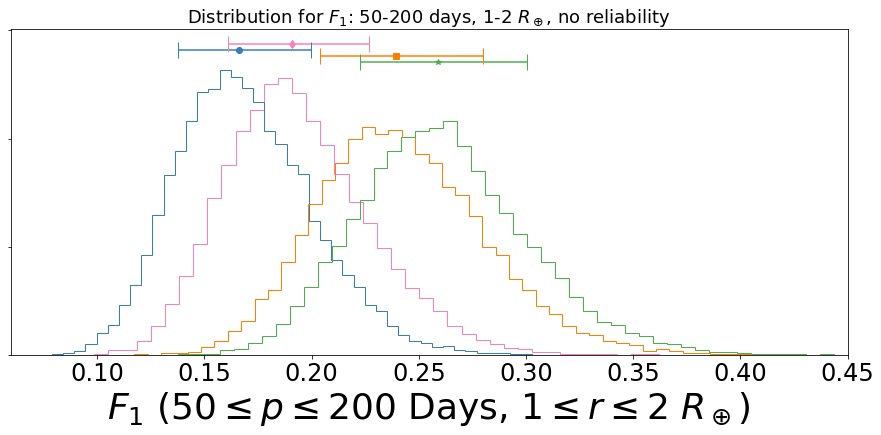

In [20]:
draw_dists(F1DistDr25Nr, F1DistHrNr, F1DistHcNr, F1DistFpwgpcNr, 0.45)
plt.xlabel(r"$F_1$ ($50 \leq p \leq 200$ Days, $1 \leq r \leq 2~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/f1DistNoReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $F_1$: 50-200 days, 1-2 $R_\oplus$, no reliability", fontsize=18);


Range of medians: 0.13 to 0.16
std of medians: 0.01 = 6.72%
peak-to-peak of medians: 0.03 = 18.94%
peak-to-peak of medians: 0.03 = 0.32 sigma
Maximum separation of medians: 0.649 sigma


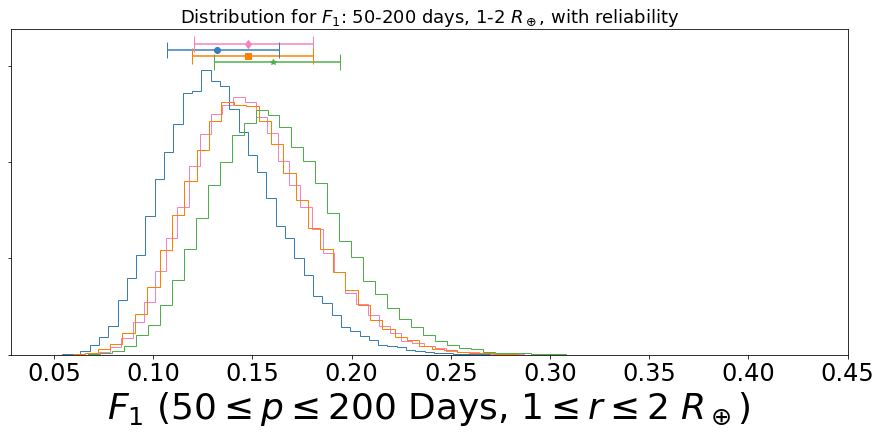

In [21]:
draw_dists(F1DistDr25Wr, F1DistHrWr, F1DistHcWr, F1DistFpwgpcWr, 0.45)
plt.xlabel(r"$F_1$ ($50 \leq p \leq 200$ Days, $1 \leq r \leq 2~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/f1DistWithReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $F_1$: 50-200 days, 1-2 $R_\oplus$, with reliability", fontsize=18);


Range of medians: 0.02 to 0.09
std of medians: 0.03 = 49.25%
peak-to-peak of medians: 0.07 = 119.17%
peak-to-peak of medians: 0.07 = 0.94 sigma
Maximum separation of medians: 2.116 sigma


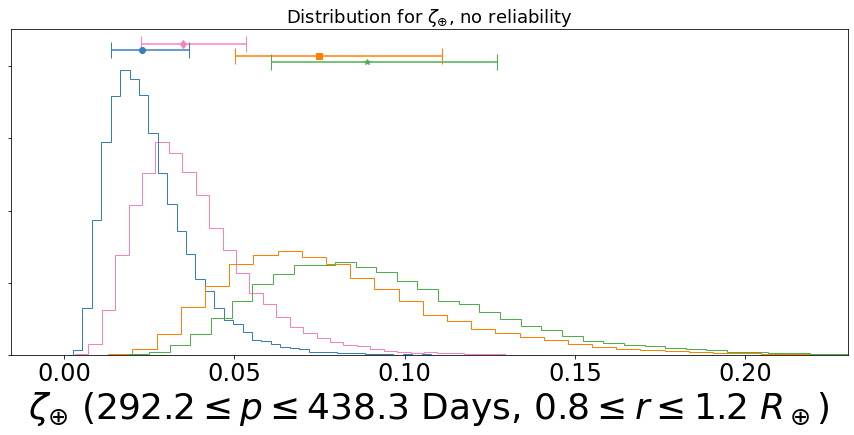

In [22]:
draw_dists(zetaEarthDistDr25Nr, zetaEarthDistHrNr, zetaEarthDistHcNr, zetaEarthDistFpwgpcNr, 0.23)
plt.xlabel(r"$\zeta_{\oplus}$ ($292.2 \leq p \leq 438.3$ Days, $0.8 \leq r \leq 1.2~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/zetaEarthDistNoReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $\zeta_{\oplus}$, no reliability", fontsize=18);


Range of medians: 0.01 to 0.02
std of medians: 0.0 = 16.56%
peak-to-peak of medians: 0.01 = 46.78%
peak-to-peak of medians: 0.01 = 0.28 sigma
Maximum separation of medians: 0.608 sigma


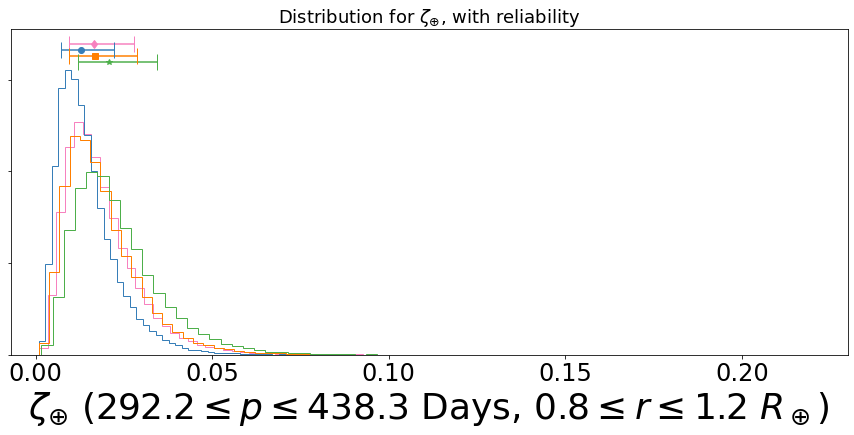

In [23]:
draw_dists(zetaEarthDistDr25Wr, zetaEarthDistHrWr, zetaEarthDistHcWr, zetaEarthDistFpwgpcWr, 0.23)
plt.xlabel(r"$\zeta_{\oplus}$ ($292.2 \leq p \leq 438.3$ Days, $0.8 \leq r \leq 1.2~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/zetaEarthDistWithReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for $\zeta_{\oplus}$, with reliability", fontsize=18);


Range of medians: 0.2 to 0.9
std of medians: 0.29 = 54.09%
peak-to-peak of medians: 0.7 = 130.17%
peak-to-peak of medians: 0.7 = 0.88 sigma
Maximum separation of medians: 2.077 sigma


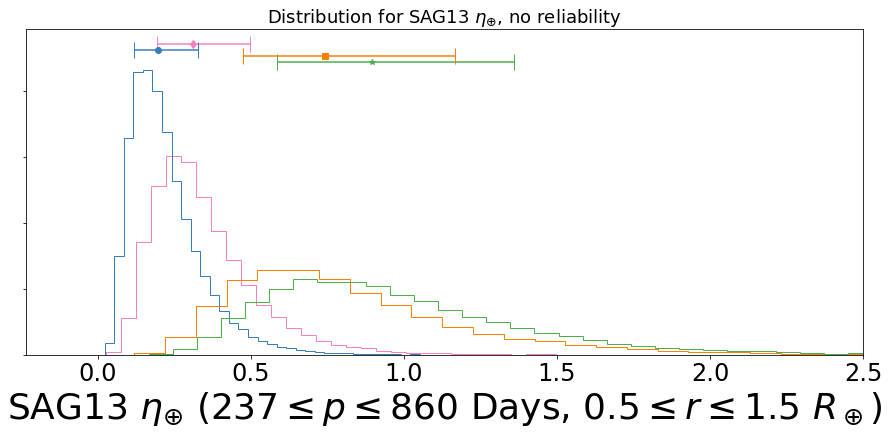

In [24]:
draw_dists(sag13etaEarthDistDr25Nr, sag13etaEarthDistHrNr, sag13etaEarthDistHcNr, sag13etaEarthDistFpwgpcNr, 2.5)
plt.xlabel(r"SAG13 $\eta_{\oplus}$ ($237 \leq p \leq 860$ Days, $0.5 \leq r \leq 1.5~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/sag13etaEarthDistNoReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for SAG13 $\eta_{\oplus}$, no reliability", fontsize=18);


Range of medians: 0.11 to 0.17
std of medians: 0.02 = 16.63%
peak-to-peak of medians: 0.07 = 46.9%
peak-to-peak of medians: 0.07 = 0.27 sigma
Maximum separation of medians: 0.583 sigma


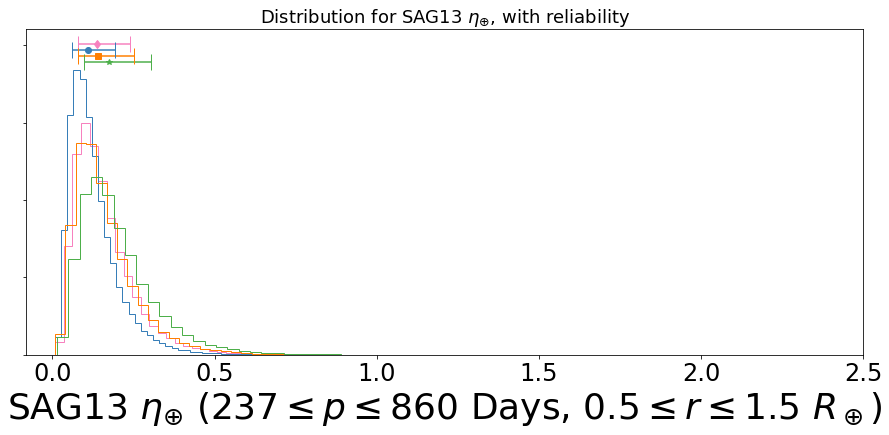

In [25]:
draw_dists(sag13etaEarthDistDr25Wr, sag13etaEarthDistHrWr, sag13etaEarthDistHcWr, sag13etaEarthDistFpwgpcWr, 2.5)
plt.xlabel(r"SAG13 $\eta_{\oplus}$ ($237 \leq p \leq 860$ Days, $0.5 \leq r \leq 1.5~R_\oplus$)", fontSize = 36);
plt.savefig(outputDir + "/sag13etaEarthDistWithReliability" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Distribution for SAG13 $\eta_{\oplus}$, with reliability", fontsize=18);


In [26]:
vetCompHR = np.load("highReliability" + dataStr + "Output/vettingCompletenessPosteriors_logisticX0xRotatedLogisticY0.npy")
vetCompHC = np.load("highCompleteness" + dataStr + "Output/vettingCompletenessPosteriors_logisticX0xRotatedLogisticY0.npy")
vetCompFpwgpc = np.load("fpwgpc" + dataStr + "Output/vettingCompletenessPosteriors_logisticX0xRotatedLogisticY0.npy")
vetCompDR25 = np.load("dr25" + dataStr + "Output/vettingCompletenessPosteriors_logisticX0xRotatedLogisticY0.npy")

vetParamsHR = pd.read_pickle("highReliability" + dataStr + "Output/vetCompletenessTable.pkl")
vetParamsHC = pd.read_pickle("highCompleteness" + dataStr + "Output/vetCompletenessTable.pkl")
vetParamsFpwgpc = pd.read_pickle("fpwgpc" + dataStr + "Output/vetCompletenessTable.pkl")
vetParamsDR25 = pd.read_pickle("dr25" + dataStr + "Output/vetCompletenessTable.pkl")


In [27]:
periodMin = 0;
periodMax = 500;
rpMin = 0.5;
rpMax = 15;
mesMin = 0;
mesMax = 30;

vetModel = "logisticX0xRotatedLogisticY0"



In [28]:
tm = vetParamsHR[vetParamsHR.Model == vetModel]
vetThetaHR = tm.medianMCMCTheta.values[0] 
tm = vetParamsHC[vetParamsHC.Model == vetModel]
vetThetaHC = tm.medianMCMCTheta.values[0] 
tm = vetParamsFpwgpc[vetParamsFpwgpc.Model == vetModel]
vetThetaFpwgpc = tm.medianMCMCTheta.values[0] 
tm = vetParamsDR25[vetParamsDR25.Model == vetModel]
vetThetaDR25 = tm.medianMCMCTheta.values[0] 


In [29]:
def compVetPost(samples, fitTheta):
    r1 = np.zeros(np.shape(samples)[0])
    xp = 365.;
    yp = 10.;
    cx = (xp - periodMin)/(periodMax - periodMin);
    cy = (yp - mesMin)/(mesMax - mesMin);
    for i in range(np.shape(samples)[0]):
        r1[i] = funcModels.rateModel(cx, cy, samples[i,:], vetModel)

    r2 = np.zeros(np.shape(samples)[0])
    xp = 365.;
    yp = 8.;
    cx = (xp - periodMin)/(periodMax - periodMin);
    cy = (yp - mesMin)/(mesMax - mesMin);
    for i in range(np.shape(samples)[0]):
        r2[i] = funcModels.rateModel(cx, cy, samples[i,:], vetModel)

    return r1, r2

In [30]:
compDistHR1, compDistHR2 = compVetPost(vetCompHR, vetThetaHR)
compDistHC1, compDistHC2 = compVetPost(vetCompHC, vetThetaHC)
compDistFpwgpc1, compDistFpwgpc2 = compVetPost(vetCompFpwgpc, vetThetaFpwgpc)
compDistDR251, compDistDR252 = compVetPost(vetCompDR25, vetThetaDR25)

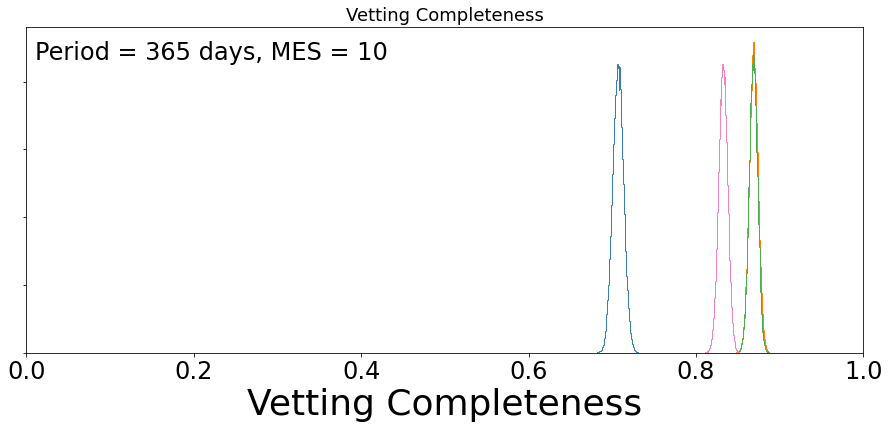

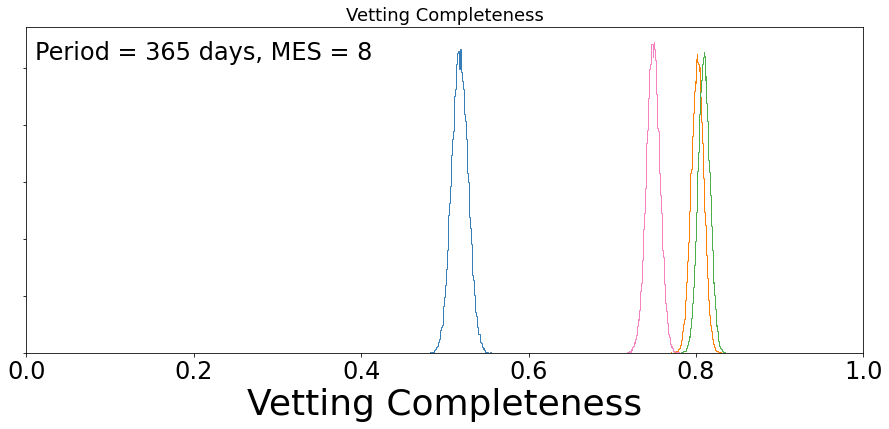

In [31]:
plt.figure(figsize=(15,6));
plt.hist(compDistHR1, 100, histtype="step", color=cbc[0]);
plt.hist(compDistHC1, 100, histtype="step", color=cbc[1]);
plt.hist(compDistFpwgpc1, 100, histtype="step", color=cbc[2]);
plt.hist(compDistDR251, 100, histtype="step", color=cbc[3]);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlim(0,1)
ylim = plt.ylim()[1];
plt.text(plt.xlim()[0] + 0.01, 0.9*ylim, "Period = 365 days, MES = 10", fontSize = 24)
plt.xlabel("Vetting Completeness", fontSize = 36);
plt.savefig(outputDir + "/vetCompletenessCompare1" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Vetting Completeness", fontsize=18);

plt.figure(figsize=(15,6));
plt.hist(compDistHR2, 100, histtype="step", color=cbc[0]);
plt.hist(compDistHC2, 100, histtype="step", color=cbc[1]);
plt.hist(compDistFpwgpc2, 100, histtype="step", color=cbc[2]);
plt.hist(compDistDR252, 100, histtype="step", color=cbc[3]);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlim(0,1)
ylim = plt.ylim()[1];
plt.text(plt.xlim()[0] + 0.01, 0.9*ylim, "Period = 365 days, MES = 8", fontSize = 24)
plt.xlabel("Vetting Completeness", fontSize = 36);
plt.savefig(outputDir + "/vetCompletenessCompare" + fnStr + ".pdf",bbox_inches='tight')
plt.title("Vetting Completeness", fontsize=18);


In [32]:
def computeReliabiltyPosterior(xp, yp, eSamples, oSamples, fpEffModel, obsModel):
    r = np.zeros(np.shape(eSamples)[0])
    for i in range(np.shape(eSamples)[0]):
        e = funcModels.evaluateModel(xp, yp, eSamples[i,:], fpEffXRange, fpEffYRange, fpEffModel)
        o = funcModels.evaluateModel(xp, yp, oSamples[i,:], obsXRange, obsYRange, obsModel)
        r[i] = 1 - (o/(1-o))*((1-e)/e)

    return r

In [33]:
obsModel = "rotatedLogisticX0"
samples = np.load("highReliability" + dataStr + "Output/jointPosteriors_"+hrFpeModel+"_rotatedLogisticX0.npy");
nFpeParams = len(funcModels.initRateModel(hrFpeModel));
eSamplesHR = samples[:,0:nFpeParams];
oSamplesHR = samples[:,nFpeParams:];

samples = np.load("highCompleteness" + dataStr + "Output/jointPosteriors_"+hcFpeModel+"_rotatedLogisticX0.npy");
nFpeParams = len(funcModels.initRateModel(hcFpeModel));
eSamplesHC = samples[:,0:nFpeParams];
oSamplesHC = samples[:,nFpeParams:];

samples = np.load("fpwgpc" + dataStr + "Output/jointPosteriors_"+fpwgpcFpeModel+"_rotatedLogisticX0.npy");
nFpeParams = len(funcModels.initRateModel(fpwgpcFpeModel));
eSamplesFpwgpc = samples[:,0:nFpeParams];
oSamplesFpwgpc = samples[:,nFpeParams:];

samples = np.load("dr25" + dataStr + "Output/jointPosteriors_"+dr25FpeModel+"_rotatedLogisticX0.npy");
nFpeParams = len(funcModels.initRateModel(dr25FpeModel));
eSamplesDR25 = samples[:,0:nFpeParams];
oSamplesDR25 = samples[:,nFpeParams:];



In [34]:

tt = pd.read_pickle("../GKbaseline/fpEffectivenessTable.pkl")
tm = tt[tt.Model == "rotatedLogisticX0"]
fpEffXRange = tm.periodRange.values[0]
fpEffYRange = tm.mesRange.values[0]
tt = pd.read_pickle("../GKbaseline/obsFpTable.pkl")
tm = tt[tt.Model == obsModel]
obsXRange = tm.periodRange.values[0]
obsYRange = tm.mesRange.values[0]

rDistHR_1 = computeReliabiltyPosterior(365., 10., eSamplesHR, oSamplesHR, hrFpeModel, obsModel)
rDistHR_2 = computeReliabiltyPosterior(365., 8., eSamplesHR, oSamplesHR, hrFpeModel, obsModel)

rDistHC_1 = computeReliabiltyPosterior(365., 10., eSamplesHC, oSamplesHC, hcFpeModel, obsModel)
rDistHC_2 = computeReliabiltyPosterior(365., 8., eSamplesHC, oSamplesHC, hcFpeModel, obsModel)

rDistFpwgpc_1 = computeReliabiltyPosterior(365., 10., eSamplesFpwgpc, oSamplesFpwgpc, fpwgpcFpeModel, obsModel)
rDistFpwgpc_2 = computeReliabiltyPosterior(365., 8., eSamplesFpwgpc, oSamplesFpwgpc, fpwgpcFpeModel, obsModel)

rDistDR25_1 = computeReliabiltyPosterior(365., 10., eSamplesDR25, oSamplesDR25, dr25FpeModel, obsModel)
rDistDR25_2 = computeReliabiltyPosterior(365., 8., eSamplesDR25, oSamplesDR25, dr25FpeModel, obsModel)


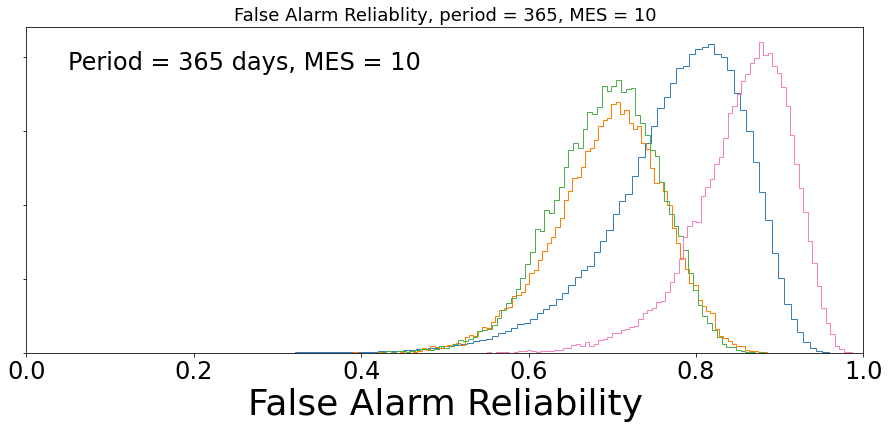

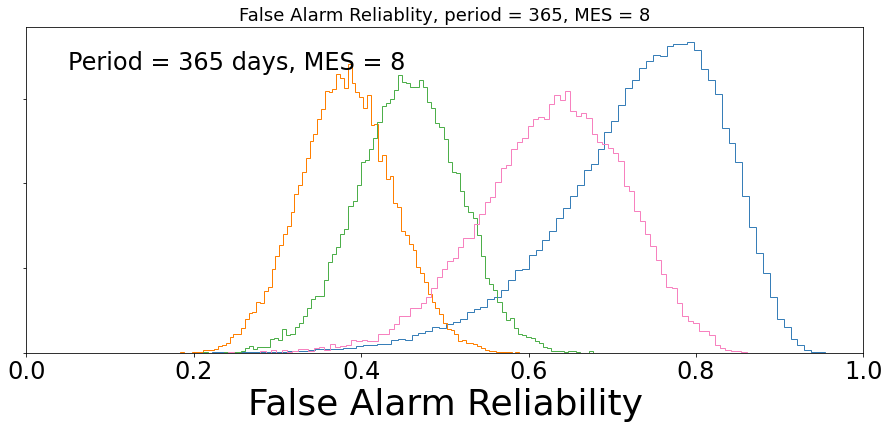

In [35]:
plt.figure(figsize=(15,6));
plt.hist(rDistHR_1, 100, histtype="step", color=cbc[0]);
plt.hist(rDistHC_1, 100, histtype="step", color=cbc[1]);
plt.hist(rDistFpwgpc_1, 100, histtype="step", color=cbc[2]);
plt.hist(rDistDR25_1, 100, histtype="step", color=cbc[3]);
plt.xlim(0,1)
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel("False Alarm Reliability", fontSize = 36);
ylim = plt.ylim()[1];
plt.text(0.05, 0.87*ylim, "Period = 365 days, MES = 10", fontSize = 24)
plt.savefig(outputDir + "/reliabilityCompare1" + fnStr + ".pdf",bbox_inches='tight')
plt.title("False Alarm Reliablity, period = 365, MES = 10", fontsize=18);

plt.figure(figsize=(15,6));
plt.hist(rDistHR_2, 100, histtype="step", color=cbc[0]);
plt.hist(rDistHC_2, 100, histtype="step", color=cbc[1]);
plt.hist(rDistFpwgpc_2, 100, histtype="step", color=cbc[2]);
plt.hist(rDistDR25_2, 100, histtype="step", color=cbc[3]);
plt.xlim(0,1)
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel("False Alarm Reliability", fontSize = 36);
ylim = plt.ylim()[1];
plt.text(0.05, 0.87*ylim, "Period = 365 days, MES = 8", fontSize = 24)
plt.savefig(outputDir + "/reliabilityCompare2" + fnStr + ".pdf",bbox_inches='tight')
plt.title("False Alarm Reliablity, period = 365, MES = 8", fontsize=18);



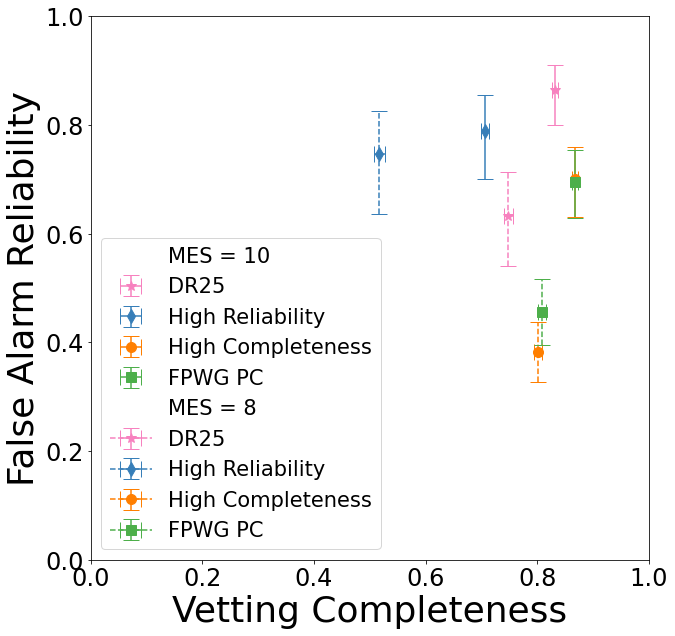

In [42]:
capsize = 8
xsize = 3
cbc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
marker = ['d', 'o', 's', '*']

plt.figure(figsize=(10,10));
rDistHRStats_1 = medianAndErrorbars(rDistHR_1)
compDistHRStats1 = medianAndErrorbars(compDistHR1)
rDistHCStats_1 = medianAndErrorbars(rDistHC_1)
compDistHCStats1 = medianAndErrorbars(compDistHC1)
rDistFpwgpcStats_1 = medianAndErrorbars(rDistFpwgpc_1)
compDistFpwgpcStats1 = medianAndErrorbars(compDistFpwgpc1)
rDistDR25Stats_1 = medianAndErrorbars(rDistDR25_1)
compDistDR25Stats1 = medianAndErrorbars(compDistDR251)
k = 3
eb1 = plt.errorbar(compDistDR25Stats1[0], rDistDR25Stats_1[0], 
             xerr = [[compDistDR25Stats1[2]], [compDistDR25Stats1[1]]], 
             yerr = [[rDistDR25Stats_1[2]], [rDistDR25Stats_1[1]]], 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
k = 0
eb2 = plt.errorbar(compDistHRStats1[0], rDistHRStats_1[0], 
             xerr = [[compDistHRStats1[2]], [compDistHRStats1[1]]], 
             yerr = [[rDistHRStats_1[2]], [rDistHRStats_1[1]]], 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
k = 1
eb3 = plt.errorbar(compDistHCStats1[0], rDistHCStats_1[0], 
             xerr = [[compDistHCStats1[2]], [compDistHCStats1[1]]], 
             yerr = [[rDistHCStats_1[2]], [rDistHCStats_1[1]]], 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
k = 2
eb4 = plt.errorbar(compDistFpwgpcStats1[0], rDistFpwgpcStats_1[0], 
             xerr = [[compDistFpwgpcStats1[2]], [compDistFpwgpcStats1[1]]], 
             yerr = [[rDistFpwgpcStats_1[2]], [rDistFpwgpcStats_1[1]]], 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)

rDistHRStats_2 = medianAndErrorbars(rDistHR_2)
compDistHRStats2 = medianAndErrorbars(compDistHR2)
rDistHCStats_2 = medianAndErrorbars(rDistHC_2)
compDistHCStats2 = medianAndErrorbars(compDistHC2)
rDistFpwgpcStats_2 = medianAndErrorbars(rDistFpwgpc_2)
compDistFpwgpcStats2 = medianAndErrorbars(compDistFpwgpc2)
rDistDR25Stats_2 = medianAndErrorbars(rDistDR25_2)
compDistDR25Stats2 = medianAndErrorbars(compDistDR252)
k = 3
eb5 = plt.errorbar(compDistDR25Stats2[0], rDistDR25Stats_2[0], 
             xerr = [[compDistDR25Stats2[2]], [compDistDR25Stats2[1]]], 
             yerr = [[rDistDR25Stats_2[2]], [rDistDR25Stats_2[1]]], ls = "--", 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
eb5[-1][1].set_linestyle('--')
k = 0
eb6 = plt.errorbar(compDistHRStats2[0], rDistHRStats_2[0], 
             xerr = [[compDistHRStats2[2]], [compDistHRStats2[1]]], 
             yerr = [[rDistHRStats_2[2]], [rDistHRStats_2[1]]], ls = "--", 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
eb6[-1][1].set_linestyle('--')
k = 1
eb7 = plt.errorbar(compDistHCStats2[0], rDistHCStats_2[0], 
             xerr = [[compDistHCStats2[2]], [compDistHCStats2[1]]], 
             yerr = [[rDistHCStats_2[2]], [rDistHCStats_2[1]]], ls = "--", 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
eb7[-1][1].set_linestyle('--')
k = 2
eb8 = plt.errorbar(compDistFpwgpcStats2[0], rDistFpwgpcStats_2[0], 
             xerr = [[compDistFpwgpcStats2[2]], [compDistFpwgpcStats2[1]]], 
             yerr = [[rDistFpwgpcStats_2[2]], [rDistFpwgpcStats_2[1]]], ls = "--", 
             capsize = capsize, color = cbc[k], fmt=marker[k], ms=10)
eb8[-1][1].set_linestyle('--')

from matplotlib.patches import Rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend([extra, eb1, eb2, eb3, eb4, extra, eb5, eb6, eb7, eb8], 
           ["MES = 10", "DR25", "High Reliability", "High Completeness", "FPWG PC", "MES = 8", "DR25", "High Reliability", "High Completeness", "FPWG PC"], 
           fontsize=21, loc="lower left")

plt.xlim(0,1)
plt.ylim(0,1)
plt.tick_params(labelsize = 24)
plt.ylabel("False Alarm Reliability", fontSize = 36);
plt.xlabel("Vetting Completeness", fontSize = 36);
plt.savefig(outputDir + "/compRelCompare" + fnStr + ".pdf",bbox_inches='tight')


In [37]:
compDistHRStats1[1], rDistHRStats_1[1]

(0.006517546244076633, 0.06504196427897835)

In [38]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [39]:
%%bash -s  "$dataStr"
jupyter nbconvert --to html compareCases.ipynb
mv compareCases.html htmlArchive/compareCases_$1.html

[NbConvertApp] Converting notebook compareCases.ipynb to html
[NbConvertApp] Writing 954727 bytes to compareCases.html
